In [1]:
import os
import email
from email import policy
from email.parser import BytesParser
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- STEP 1: FUNCTION TO PARSE A SINGLE EMAIL ---

def parse_email_from_file(Data):
    """Parses a single .eml or .txt file to extract its content."""
    with open(Data, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    
    body = ''
    if msg.is_multipart():
        for part in msg.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                break
    else:
        body = msg.get_payload(decode=True).decode('utf-8', errors='ignore')
        
    # Clean up the body text by removing HTML tags
    soup = BeautifulSoup(body, 'html.parser')
    clean_body = soup.get_text()
    
    return {
        'subject': msg['subject'],
        'from': msg['from'],
        'body': clean_body
    }

In [3]:
# --- STEP 2: LOAD ALL EMAILS FROM DATA FOLDERS ---

print("Loading emails from raw data folders...")
# Define the correct paths to your new spam and ham subfolders
spam_dir = 'Phishing_Detection_model/Data/spam'
ham_dir = 'Phishing_Detection_model/Data/ham'

emails = []

# First loop: Load spam emails and label them as phishing (1)
print(f"Loading files from: {spam_dir}")
for filename in os.listdir(spam_dir):
    # Ignore hidden system files like .DS_Store
    if not filename.startswith('.'):
        file_path = os.path.join(spam_dir, filename)
        content = parse_email_from_file(file_path)
        content['is_phishing'] = 1
        emails.append(content)

# Second loop: Load ham emails and label them as safe (0)
print(f"Loading files from: {ham_dir}")
for filename in os.listdir(ham_dir):
     # Ignore hidden system files
     if not filename.startswith('.'):
        file_path = os.path.join(ham_dir, filename)
        content = parse_email_from_file(file_path)
        content['is_phishing'] = 0
        emails.append(content)

# The rest of the process is the same
df = pd.DataFrame(emails)
print(f"\nLoaded {len(df)} emails successfully.")
print("Sample of the loaded data:")
display(df.head())

Loading emails from raw data folders...
Loading files from: Phishing_Detection_model/Data/spam


/var/folders/tn/twpv_bvs0mdcnkbzy21mh_hw0000gn/T/ipykernel_75038/2412238946.py:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(body, 'html.parser')


Loading files from: Phishing_Detection_model/Data/ham


/var/folders/tn/twpv_bvs0mdcnkbzy21mh_hw0000gn/T/ipykernel_75038/2412238946.py:20: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(body, 'html.parser')



Loaded 3052 emails successfully.
Sample of the loaded data:


,subject,from,body,is_phishing
0,"Friend, Copy ANY DVD or Playstation Game with ...",CopyYourDVD <atomica2020@hotmail.com>,"Friend,Now you can copy DVD's and Games\nhttp:...",1
1,5% Guaranteed for Eight Years,IQ - Safe Harbor <sh@insiq.us>,Pocket the newest 8 year annuity!\t Pocket th...,1
2,Congratulations! You Get a Free Handheld Organ...,Customer Service <greatoffers@sendgreatoffers....,\nCongratulations! You Get a Free Handheld Org...,1
3,One of a kind Money maker! Try it for free!,Ben Green <bengreen@mindupmerchants.com>,,1
4,Online Doctors will fill your Viagra Prescript...,viagra_medication1182@martyrs.com.au,YOUR SEX DRIVE SHOULD NEVER BE SECOND ON THE L...,1


In [4]:
# --- STEP 3: FEATURE ENGINEERING ---
# [cite_start]We will create "email metadata and content-based features" to detect attacks[cite: 39].
print("\nEngineering features...")

def extract_features(df):
    # Make sure 'body' and 'subject' columns are strings
    df['body'] = df['body'].astype(str)
    df['subject'] = df['subject'].astype(str)

    # 1. Body Length
    df['body_length'] = df['body'].str.len()
    
    # 2. Subject Length
    df['subject_length'] = df['subject'].str.len()

    # 3. Count of Suspicious Keywords (content-based)
    suspicious_keywords = ['verify', 'update', 'login', 'urgent', 'account', 'password', 'suspend', 'confirm']
    df['suspicious_keyword_count'] = df['body'].apply(lambda x: sum(keyword in x.lower() for keyword in suspicious_keywords))
    
    # 4. Count of URLs (metadata)
    df['url_count'] = df['body'].apply(lambda x: len(re.findall(r'http[s]?://', x)))
    
    # 5. Count of Special Characters
    df['special_char_count'] = df['body'].apply(lambda x: len(re.findall(r'[!$%^&*()]', x)))
    
    return df

df_features = extract_features(df.copy())
print("Feature engineering complete.")
print("Sample of data with new features:")
# Display only the new feature columns and the target
display(df_features[['body_length', 'subject_length', 'suspicious_keyword_count', 'url_count', 'special_char_count', 'is_phishing']].head())



Engineering features...
Feature engineering complete.
Sample of data with new features:


,body_length,subject_length,suspicious_keyword_count,url_count,special_char_count,is_phishing
0,1773,65,0,5,14,1
1,863,29,0,1,6,1
2,1585,51,1,1,14,1
3,0,43,0,0,0,1
4,1304,76,0,6,11,1



Visualizing a feature...


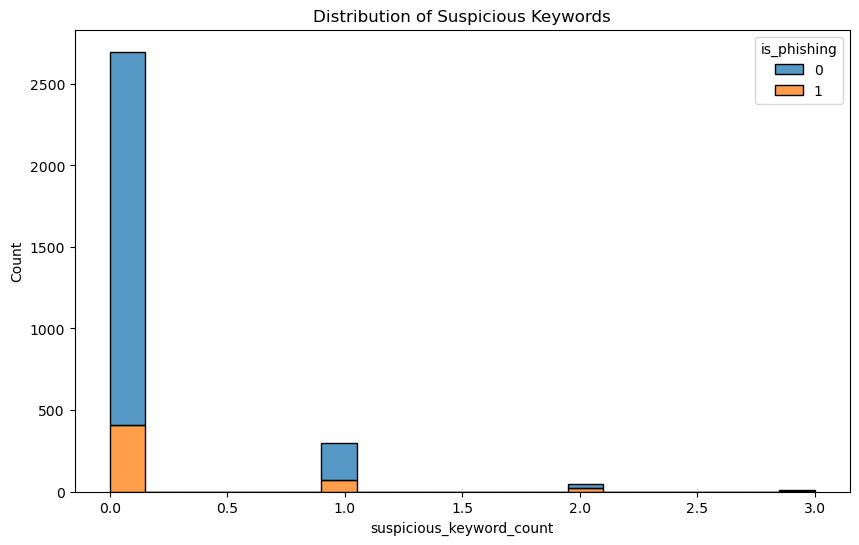

In [5]:
# --- STEP 4: EXPLORATORY DATA ANALYSIS (EDA) ---
print("\nVisualizing a feature...")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_features, x='suspicious_keyword_count', hue='is_phishing', multiple='stack', bins=20)
plt.title('Distribution of Suspicious Keywords')
plt.show()

In [6]:
# --- STEP 5: SAVE THE PROCESSED DATAFRAME ---

# Drop the raw text columns before saving
df_final = df_features.drop(columns=['subject', 'from', 'body'])

# Define the path for the folder you want to create
output_folder = 'Phishing_Detection_model/processed'
# Use os.makedirs() to create the folder. exist_ok=True prevents an error if it already exists.
os.makedirs(output_folder, exist_ok=True)

# Define the full path to the output file
output_path = os.path.join(output_folder, 'email_features.csv')

# Now, save the file to the newly created directory
df_final.to_csv(output_path, index=False)

print(f"\nProcessed data with features saved to: {output_path}")


Processed data with features saved to: Phishing_Detection_model/processed/email_features.csv


In [7]:
!ls -l Phishing_Detection_model/processed/

total 96
-rw-r--r--  1 om  staff  47849 Jul 23 15:44 email_features.csv
